# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.
В практических примерах ниже показано:
+ как делать перекодировку признаков в номинальной и порядковой шкалах
+ как вырастить дерево и сделать обрезку его ветвей
+ как настроить модель бэггинга
+ как вырастить случайный лес
+ как настроить модель бустинга на деревьях решений
+ как подбирать настроенные параметры моделей методом сеточного поиска
Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.

# Загружаем пакеты

In [1]:
import sklearn
print(sklearn.__version__)

0.22.1


In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report

In [3]:
# константы
# ядро для генератора случайных чисел
my_seed = 18
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру

In [4]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
 display(Markdown(string))

# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)
# функция, которая строит график важности признаков в модели случайного леса
# источник: https://www.analyseup.com/learn-python-for-data-science/python-rand
def plot_feature_importance(importance, names, model_type):
 #Create arrays from feature importance and feature names
 feature_importance = np.array(importance)
 feature_names = np.array(names)
 #Create a DataFrame using a Dictionary
 data={'feature_names':feature_names,'feature_importance':feature_importance}
 fi_df = pd.DataFrame(data)
 #Sort the DataFrame in order decreasing feature importance
 fi_df.sort_values(by=['feature_importance'], ascending=False,
 inplace=True)
 #Define size of bar plot
 plt.figure(figsize=(10,8))
 #Plot Searborn bar chart
 sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
 #Add chart labels
 plt.title('Важность признаков в модели: ' + model_type)
 plt.xlabel('Важность признака')
 plt.ylabel('')

# Загружаем данные:

In [5]:
fileURL = "https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv"
DF_all = pd.read_csv(fileURL)
# загружаем таблицу и превращаем её во фрейм
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


### Откладываем 15% наблюдений для прогноза
+ оставляем только нужные перменные

In [6]:
DF_all.drop(['PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5',
             'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5',
             'PAY_AMT6'], axis=1, inplace=True)
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2
24484,20000,1,3,2,48,-1,-1
15333,180000,2,2,2,37,-1,-1
25206,110000,2,2,2,23,-1,-1
9373,30000,2,3,1,45,1,2
20646,100000,1,2,2,31,1,2


In [7]:
# первые 5 строк фрейма у столбцов 8-11
DF.iloc[:, 7:11].head(5)

,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3
24484,-2,170,-220,-610
15333,-2,491,0,0
25206,-1,541,541,541
9373,2,29334,28198,29497
20646,2,36204,37412,36537


In [8]:
# первые 5 строк фрейма у столбцов 12-14
DF.iloc[:, 11:].head(5)

,Y
24484,0
15333,0
25206,0
9373,0
20646,0


In [9]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.

In [10]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
Y            0
dtype: int64

Пропусков не обнаружено.

## Предварительный анализ данных
### Описательные статистики
Считаем доли классов целевой переменной ***Y*** .

In [11]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [12]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.778
1    0.222
Name: Y, dtype: float64

Итак, всего целевых классов два, и их доли сильно разняться, с перевесом в пользу класса
'0'. Все объясняющие переменные набора данных непрерывные. Рассчитаем для них
описательные статистики.

In [13]:
# описательные статистики
DF.iloc[:, :6].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167241.556078,1.604784,1.854745,1.552353,35.492824,-0.016353
std,129380.470154,0.488907,0.793419,0.522415,9.211669,1.123605
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000


In [14]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3
count,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04
mean,-0.134039,-0.163294,50859.138510,48834.759882,4.673300e+04
std,1.196323,1.196063,72865.949211,70425.262890,6.907844e+04
min,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05
25%,-1.000000,-1.000000,3565.000000,2990.000000,2.635750e+03
50%,0.000000,0.000000,22330.000000,21084.000000,2.003500e+04
75%,0.000000,0.000000,66635.500000,63277.250000,5.967425e+04
max,8.000000,8.000000,653062.000000,743970.000000,1.664089e+06


Выводы по описательным статистикам: значения объясняющих переменных положительные кроме 'PAY_2', 'PAY_3'
масштабы измерения отличаются. Для работы с методами снижения размерности и
регуляризации понадобится стандартизация значений.

## Визуализация разброса переменных внутри классов
Поскольку в наборе данных 11 объясняющих переменных, и все они непрерывные (кроме поля 'SEX'), анализ
матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для
объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.

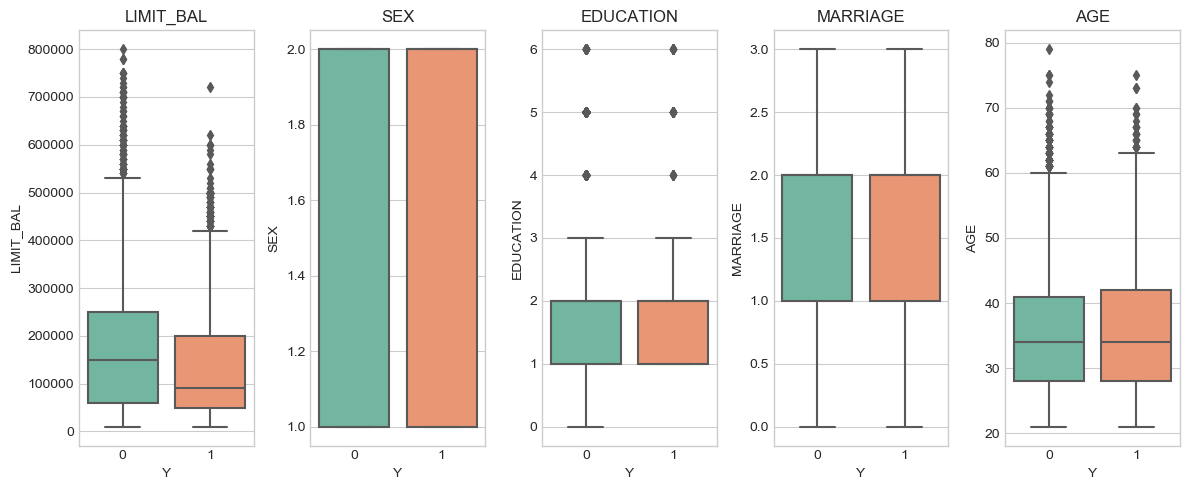

In [15]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
    
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

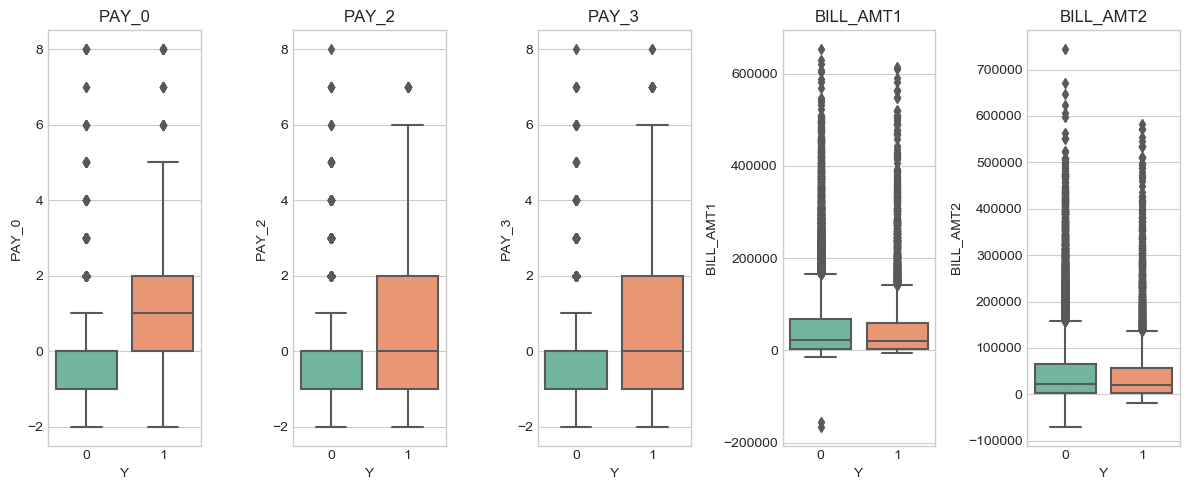

In [16]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

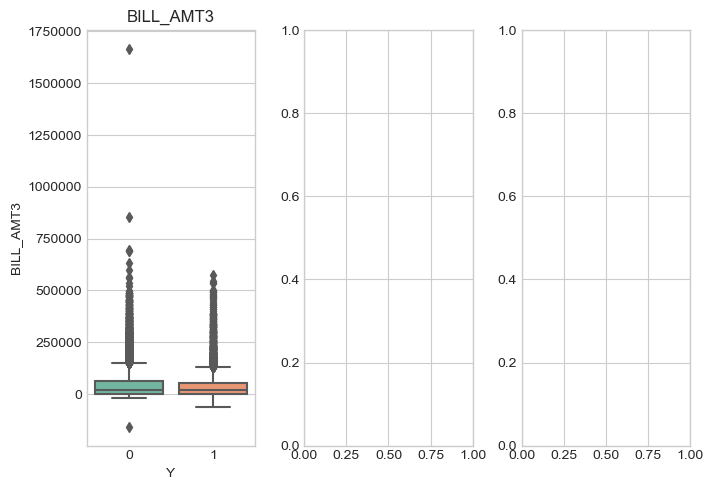

In [17]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(7.2, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
axs = [ax1, ax2, ax3]
cols_loop = list(DF.columns[10:11].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()


На графиках  сходство в медианах и разбросе между классами прослеживается практически по
всем объясняющим переменным кроме `LIMIT_BAL, PAY_0, PAY_2, PAY_3`. Меньше всего различаются коробчатые диаграммы по
переменной `EDUCATION, MARRIAGE, AGE, BILL_AMT1, BILL_AMT2, BILL_AMT3` . Это говорит о том, классы по зависимой переменной **Y** неплохо
разделяются по всем объясняющим переменным.

## Корреляционный анализ
Теперь посмотрим на взаимодействие объясняющих переменных.

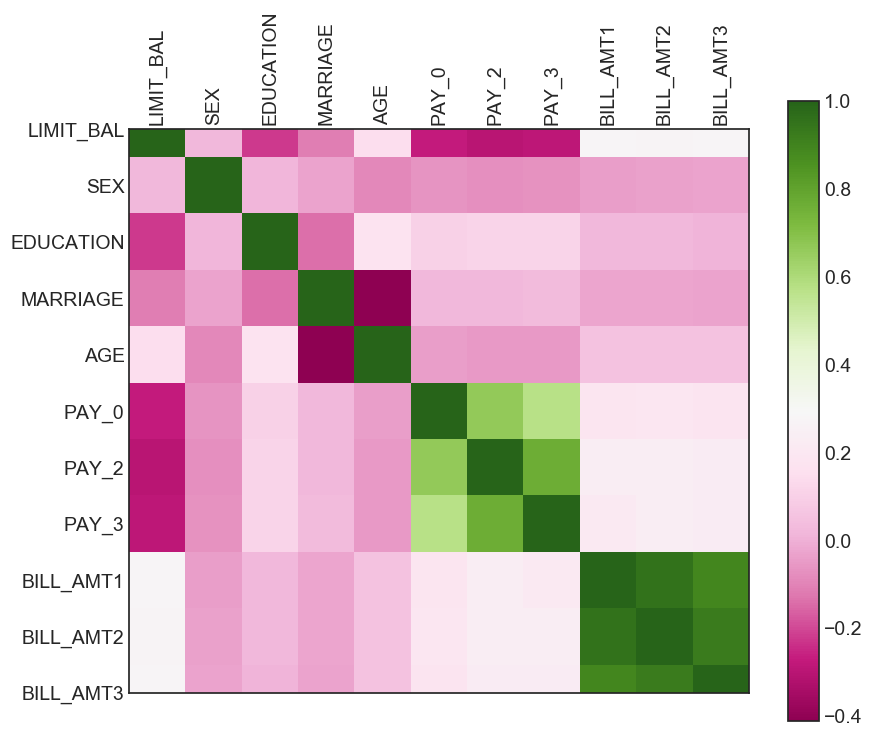

In [18]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns
# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')
# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные
взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим
минимальный / максимальный из них.

## Модель дерева
В этом разделе построим: 
+ дерево классификации
+ дерево классификации с обрезкой ветвей

## Дерево на всех признаках
Построим модель и выведем изображение дерева в виде текста.

In [19]:
# выращиваем дерево на всех объясняющих
X = DF.drop(['Y'], axis=1)
y = DF['Y']
# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
 random_state=my_seed)
tree_full = cls_one_tree.fit(X, y)
# выводим количество листьев (количество узлов)
tree_full.get_n_leaves()

4688

In [20]:
# глубина дерева: количество узлов от корня до листа
# в самой длинной ветви
tree_full.get_depth()

55

Очевидно, дерево получилось слишком большое для отображения в текстовом формате.
Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности
с перекрёстной проверкой.

In [21]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
 scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')
print('Acc с перекрёстной проверкой',
 '\nдля модели', score_models[0], ':', score[0])


Acc с перекрёстной проверкой 
для модели one_tree : 0.729


## Дерево с обрезкой ветвей
Подберём оптимальное количество ветвей, которое максимизирует , для экономии
времени рассчитанный методом проверочной выборки.

In [22]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1745
Энтропия листьев для первых 5 значений alpha: [0.00226566 0.00226566 0.00228489 0.00230411 0.00233372]


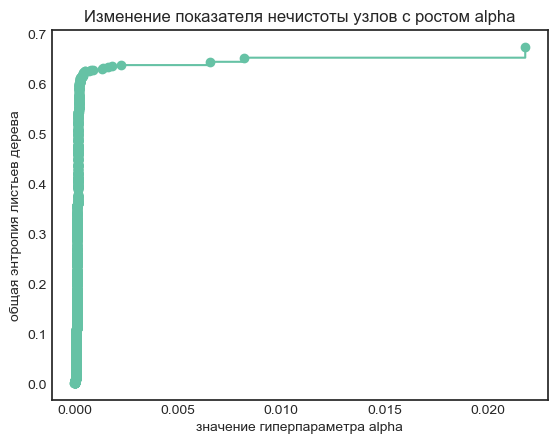

In [24]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()


In [25]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y,
 random_state=my_seed)
# модели
clfs = list()
# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
 clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
 clf.fit(X_train, y_train)
 clfs.append(clf)
# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 214.40 секунд


In [26]:
# извлекаем характеристики глубины и точности
# таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
# таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 6.17 секунд


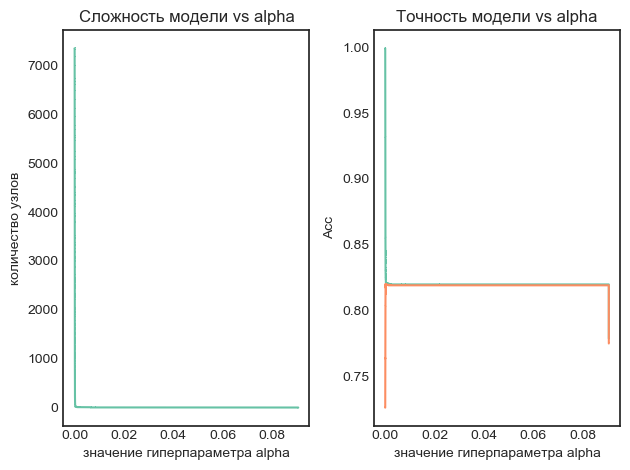

In [27]:

# изображаем на графике
fig, ax = plt.subplots(1, 2)
# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")
# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
 drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
 drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели vs alpha")
fig.tight_layout()


Находим оптимальный размер дерева по максимуму на тестовой выборке.

In [28]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
 scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')
print('Оптимальное количество узлов:', opt_nodes_num,
 '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
 '\n\nAcc с перекрёстной проверкой',
 '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 141 
соответствующая Acc на тестовой: 0.82 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.761


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [29]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

1655

In [30]:
# глубина дерева: количество узлов от корня до листа
# в самой длинной ветви
clfs[opt_nodes_num].get_depth()


38

## Бустинг
Подберём сеточным поиском настроечные параметры модели:
+ B число деревьев
+ λ – скорость обучения
+ d – глубина взаимодействия предикторов

In [32]:
# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)
# обучаем модель с параметрами по умолчанию
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
 max_depth=1, random_state=my_seed)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)

0.819

In [33]:
# настроим параметры бустинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
 'learning_rate' : np.linspace(start=0.01, stop=0.25, num=15),
 'max_depth' : [1, 2]}
# таймер
tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(),
 param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 275.14 секунд


In [34]:
# точность лучшей модели
np.around(boost_tree.best_score_, 3)


0.821

In [35]:
# параметры лучшей модели
print('n_estimators:',
 boost_tree.best_estimator_.get_params()['n_estimators'],
 '\nlearning_rate:',
 boost_tree.best_estimator_.get_params()['learning_rate'],
 '\nmax_depth:',
 boost_tree.best_estimator_.get_params()['max_depth'])


n_estimators: 30 
learning_rate: 0.23285714285714287 
max_depth: 2


In [37]:
# записываем точность
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')
print('Acc с перекрёстной проверкой',
 '\nдля модели', score_models[3], ':', score[3])

Acc с перекрёстной проверкой 
для модели boost_tree_GS : 0.821


## Прогноз на отложенные наблюдения по лучшей модели
Ещё раз посмотрим на точность построенных моделей.

In [38]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.729
1,pruned_tree,0.761
2,boost_tree_GS,0.821
3,boost_tree_GS,0.821


Все модели показывают среднюю точность по показателю , при этом самой точной
оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения.

In [41]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))

NameError: name 'random_forest' is not defined